# Object detection

There are a tons of github repositories with PyToch models: official models, non-official models, forks of non-official models, forks of forks and so on. Some of them have infratructure for training, testing, dataset downloading, generation etc. But most of them still be very complicated. It is hard to understand the code broken on thounthand files. Here we provide simple, self-contained object localizator.

## Imports
We need NumPy, Pandas, Matplotlib, OpenCV and PyTorch to complete our task

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

Define path for models

In [2]:
restore_model_from = None
save_model_to = './Models/Detection/localizator-100-epoch'

## Explore data

It is always a good idea to plot your data and visualize labels. Ensure yourself that you are not going to work with bullshit

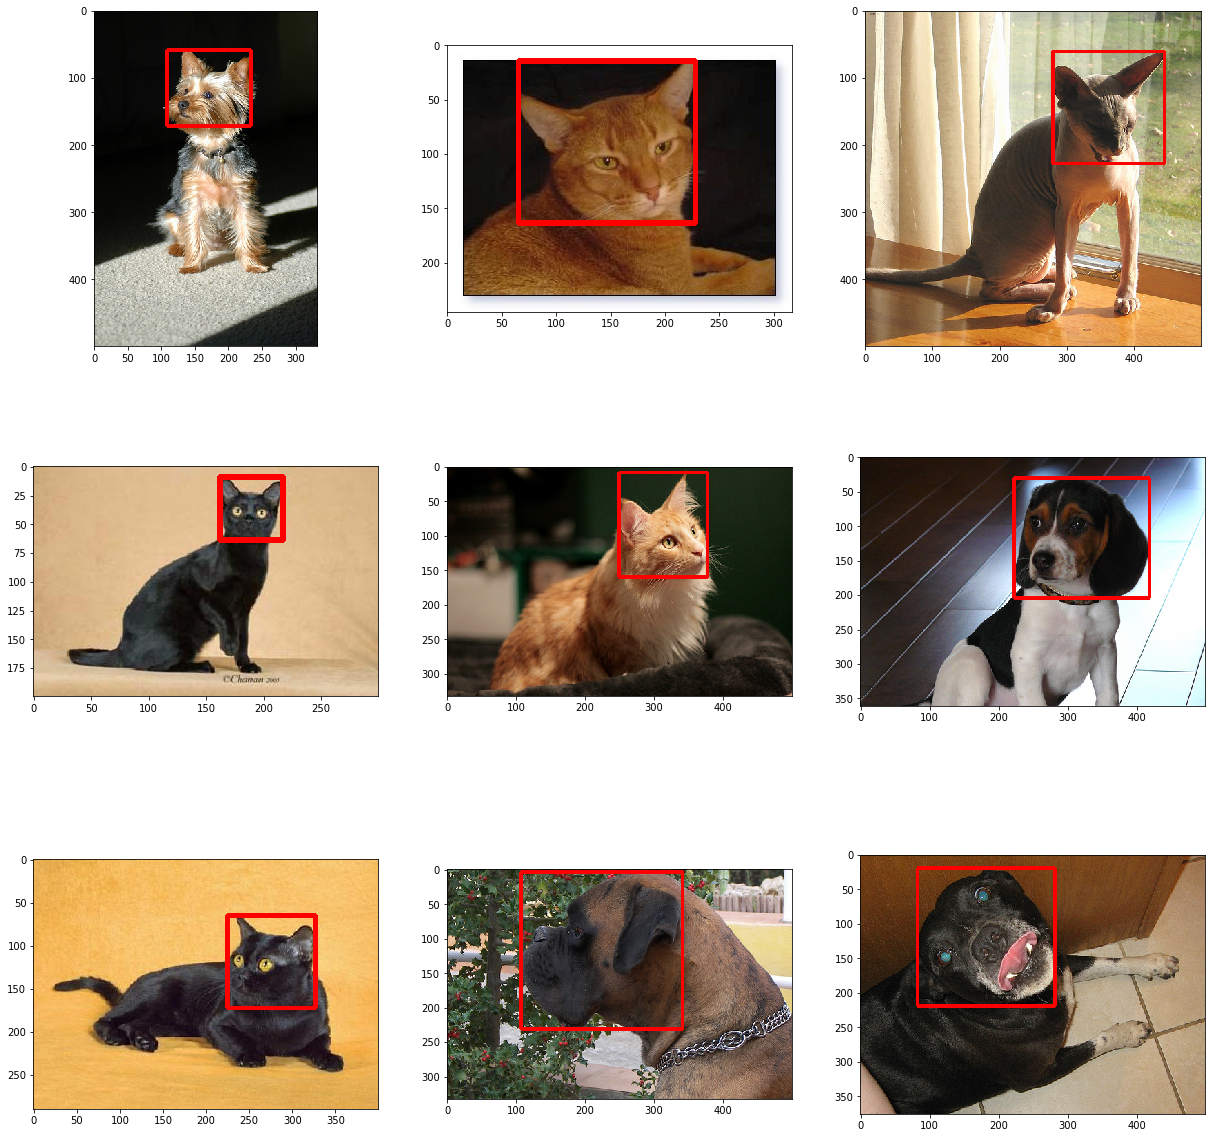

In [3]:
df = pd.read_csv('./Data/CatVsDog/dataset.csv')
df = df.sample(frac=1)

ncols = 3
nrows = 3

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*7, 7*nrows))
ax = ax.flatten()

for i, (idx, sample) in enumerate(df[~df.xmin.isna()].sample(ncols*nrows).iterrows()):
    img = cv2.imread(sample['file'])
    img = cv2.rectangle(img, (int(sample['xmin']), int(sample['ymin'])), (int(sample['xmax']), int(sample['ymax'])), (0, 0, 255), 3)
    ax[i].imshow(img[:, :, ::-1])

## Prepare dataset for PyTorch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DetectionDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataframe, dsize=(224,224)):
        self.dataframe = dataframe[~dataframe.xmin.isna()].sample(frac=1).copy()
        self.dsize = dsize
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        img = cv2.imread(sample['file'])
        img = DetectionDataset.preprocess_img(img)
        bb = np.array([sample['center_x'], sample['center_y'], sample['w_rel'], sample['h_rel']])
        return img, torch.Tensor(bb)
    
    @staticmethod
    def preprocess_img(img, dsize=(224,224)):
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32)
        img /= 255
        img = np.moveaxis(img, -1, 0)
        return torch.Tensor(img)

## Create random train/test split

In [5]:
train_df = df.iloc[:int(len(df)*0.8)]
test_df = df.iloc[int(len(df)*0.8):]
dataset = DetectionDataset(train_df)
test_dataset = DetectionDataset(test_df)

## IoU metric

Here are util for IoU calculation
<img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png"/>

In [6]:
def bb_intersection_over_union(pred, gt):
    boxA = [pred[0]-pred[2]/2, pred[1]-pred[3]/2, pred[0]+pred[2]/2, pred[1]+pred[3]/2]
    boxB = [gt[0]-gt[2]/2, gt[1]-gt[3]/2, gt[0]+gt[2]/2, gt[1]+gt[3]/2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

Here are util for converting model output to 2 points of bounding box

In [7]:
def output_to_bbox(pred):
    xmin = pred[0]-pred[2]/2
    xmax = pred[0]+pred[2]/2
    ymin = pred[1]-pred[3]/2
    ymax = pred[1]+pred[3]/2
    return xmin, ymin, xmax, ymax

Util for converting tensor form computation graph to numpy

In [8]:
def tensor_to_numpy(t):
     return t.to('cpu').detach().numpy()

## Model

Here are simple model that uses pretrained VGG16 model as backbone

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(392, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)
        
        self.extr =  nn.Sequential(*list(models.vgg16(pretrained=True).children())[:-1])
        self.reduce = nn.Conv2d(512, 8, 1)
        
    def forward(self, x, bs):
        
        x = self.extr(x)
        x = self.reduce(x)
        x = x.view(bs, 392)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x


net = Net()
net.to(device);
if restore_model_from is not None:
    net.load_state_dict(torch.load(restore_model_from))

## Train step

Train one epoch

In [10]:
def train_step(dataloader, batch_size):
    running_loss = 0.0
    mIoU = []
    for i, data in enumerate(trainloader, 1):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs, batch_size)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        for j in range(batch_size):
            iou = bb_intersection_over_union(tensor_to_numpy(labels[j]), tensor_to_numpy(outputs[j]))
            mIoU.append(iou)

        running_loss += loss.item()
    total_loss = running_loss / i
    return total_loss, np.mean(mIoU)

## Test step

Test one epoch

In [11]:
def test_step(dataloader, batch_size):
    running_loss = 0.0
    mIoU = []
    for i, data in enumerate(trainloader, 1):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs, batch_size)
            
        loss = criterion(outputs, labels)
        loss.backward()
        
        for j in range(batch_size):
            iou = bb_intersection_over_union(tensor_to_numpy(labels[j]), tensor_to_numpy(outputs[j]))
            mIoU.append(iou)

        running_loss += loss.item()
    total_loss = running_loss / i
    return total_loss, np.mean(mIoU)

In [12]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)
batch_size = 16
epochs = 100
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, drop_last=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, drop_last=True)

train_log = {'loss': [], 'iou': []}
test_log = {'loss': [], 'iou': []}
for epoch in range(epochs):  # loop over the dataset multiple times
    start_train = time.time()
    train_loss, train_iou = train_step(trainloader, batch_size)
    start_test = time.time()
    test_loss, test_iou = test_step(testloader, batch_size)
    end_test = time.time()
    
    if save_model_to is not None and epoch > 2 and test_iou > np.max(test_log['iou']):
        torch.save(net.state_dict(), '{}-iou-best'.format(save_model_to))
    
    train_log['loss'].append(train_loss)
    train_log['iou'].append(train_iou)
    test_log['loss'].append(test_loss)
    test_log['iou'].append(test_iou)
    print('{} | Loss: {:0.6f}, {:0.6f} | IoU: {:0.4f}, {:0.4f} \t Train step: {:0.2f}s Test step: {:0.2f}s '.format(epoch, train_loss, test_loss, train_iou, test_iou,
                                                                                                               start_test-start_train, end_test-start_test))
                
print('Finished Training')

0 | Loss: 0.061435, 0.012580 | IoU: 0.2435, 0.4513 	 Train step: 22.34s Test step: 22.14s 
1 | Loss: 0.010591, 0.008609 | IoU: 0.4868, 0.5166 	 Train step: 22.40s Test step: 22.16s 
2 | Loss: 0.008097, 0.006985 | IoU: 0.5316, 0.5535 	 Train step: 22.47s Test step: 22.22s 
3 | Loss: 0.006810, 0.006182 | IoU: 0.5583, 0.5715 	 Train step: 22.47s Test step: 22.24s 
4 | Loss: 0.005953, 0.005429 | IoU: 0.5779, 0.5877 	 Train step: 22.42s Test step: 22.20s 
5 | Loss: 0.005345, 0.004838 | IoU: 0.5925, 0.6078 	 Train step: 22.47s Test step: 22.20s 
6 | Loss: 0.004837, 0.004439 | IoU: 0.6078, 0.6153 	 Train step: 22.37s Test step: 22.09s 
7 | Loss: 0.004410, 0.004097 | IoU: 0.6185, 0.6272 	 Train step: 22.44s Test step: 22.16s 
8 | Loss: 0.004088, 0.003859 | IoU: 0.6279, 0.6336 	 Train step: 22.42s Test step: 22.24s 
9 | Loss: 0.003807, 0.003500 | IoU: 0.6380, 0.6467 	 Train step: 22.43s Test step: 22.17s 
10 | Loss: 0.003541, 0.003293 | IoU: 0.6452, 0.6525 	 Train step: 22.44s Test step: 22.22s

## Visualize training process

Text(0.5, 1.0, 'IoU history')

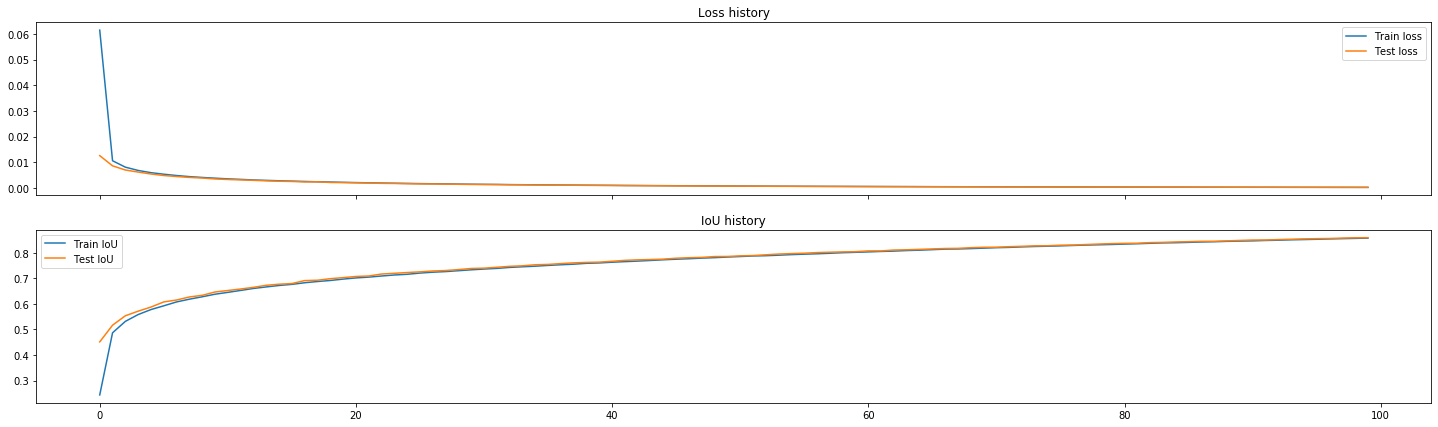

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(25, 7), sharey=False, sharex=True)
ax[0].plot(np.arange(0, epochs, 1), train_log['loss'], label='Train loss')
ax[0].plot(np.arange(0, epochs, 1), test_log['loss'], label='Test loss')
ax[1].plot(np.arange(0, epochs, 1), train_log['iou'], label='Train IoU')
ax[1].plot(np.arange(0, epochs, 1), test_log['iou'], label='Test IoU')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Loss history')
ax[1].set_title('IoU history')

## Save model

In [14]:
if save_model_to is not None:
    torch.save(net.state_dict(), save_model_to)

Util for plotting predicted bounding box

In [15]:
def plot_prediction(img, pred, color=(0, 255, 0)):
    xmin, ymin, xmax, ymax = output_to_bbox(pred)
    pt1 = int(xmin*img.shape[1]), int(ymin*img.shape[0])
    pt2 = int(xmax*img.shape[1]), int(ymax*img.shape[0])
    img = cv2.rectangle(img, pt1, pt2, color, 3)
    return img

Util for plotting ground truth bounding box

In [16]:
def plot_gt(img, rect):
    xmin = rect[0]
    xmax = rect[1]
    ymin = rect[2]
    ymax = rect[3]
    pt1 = int(xmin*img.shape[1]), int(ymin*img.shape[0])
    pt2 = int(xmax*img.shape[1]), int(ymax*img.shape[0])
    img = cv2.rectangle(img, pt1, pt2, (0, 0, 255), 2)
    return img

## Visualize predictions on test set

Red bounding box - ground truth
Green bounding box - model prediction

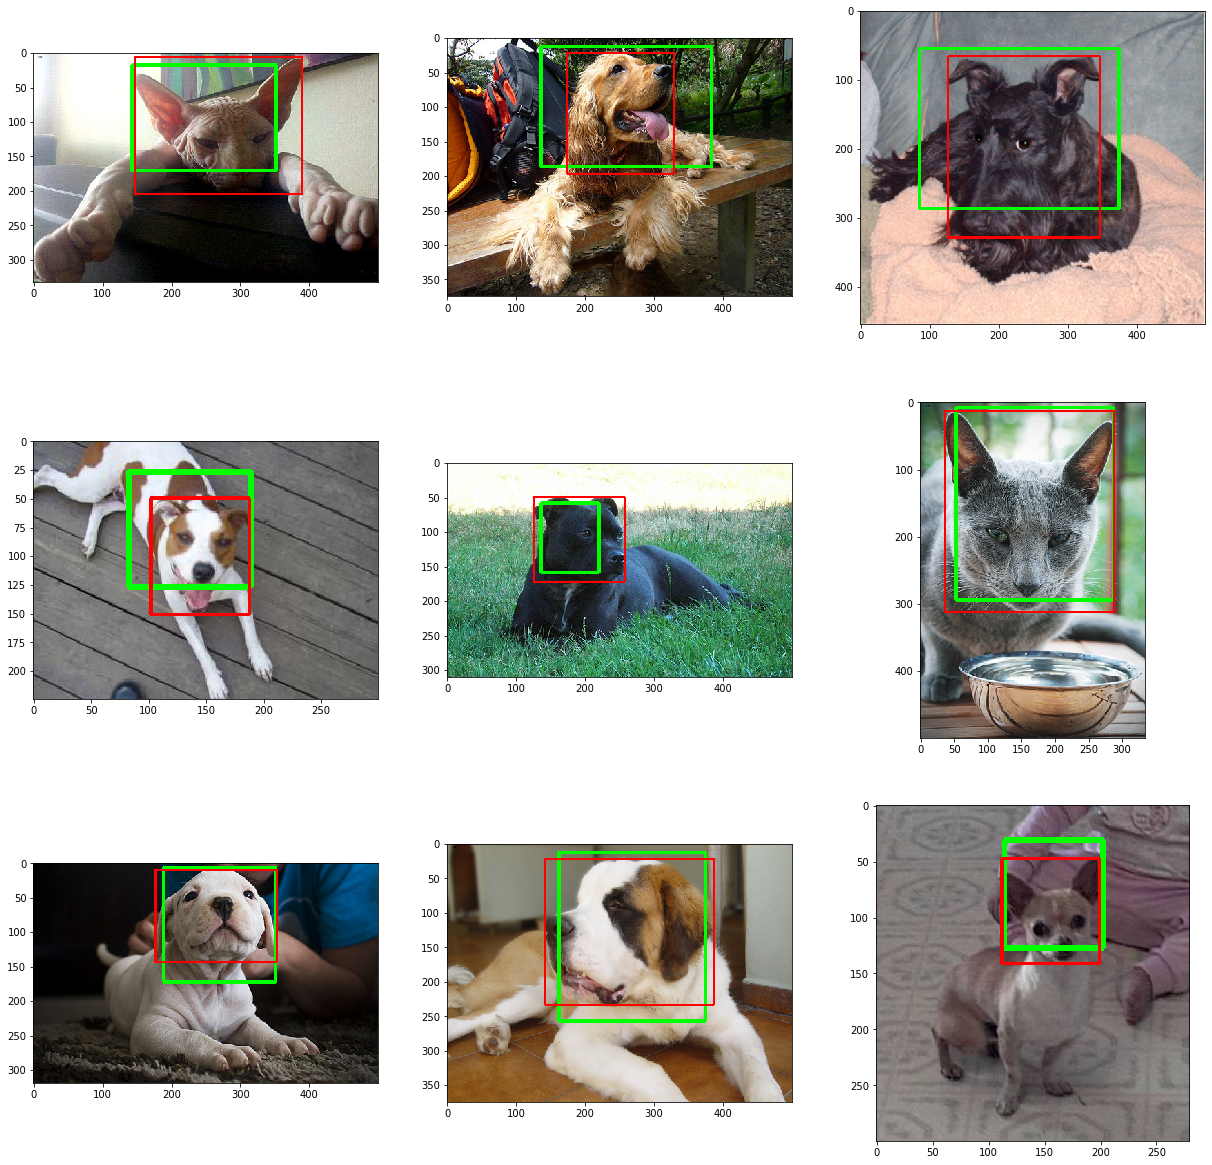

In [17]:
ncols = 3
nrows = 3
not_tested = df[~df.xmin.isna()]
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*7, 7*nrows))
ax = ax.flatten()

for vid, (idx, i) in enumerate(test_df[~test_df.xmin.isna()].sample(ncols*nrows).iterrows()):
    img = cv2.imread(i['file'])
    ipt = DetectionDataset.preprocess_img(img)
    ipt = ipt.unsqueeze(0)
    ipt = ipt.to(device)
    pred = net(ipt, 1)
    vis = plot_prediction(img, pred[0])
    vis = plot_gt(vis, [i['xmin_rel'], i['xmax_rel'], i['ymin_rel'], i['ymax_rel']])
    ax[vid].imshow(vis[:, :, ::-1])